# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
book_cost

,Book Cost
Ticker,
BTCUSDT,69141.710000
TRXUSDT,0.164146
JASMYUSDT,0.035478
SOLUSDT,146.170000
OMUSDT,1.150000
ETHUSDT,3810.480000
BBUSDT,0.398000
BNBUSDT,674.930000
PEPEUSDT,0.000002


In [8]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [9]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [10]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))

realized_loss=63.514078
pnl.loc['Loss']=0
pnl.loc['Loss']['Book Cost']=realized_loss
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']

pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,574.5640,0.2823,-37.3940
TRXUSDT,79.6748,74.3130,0.0365,-5.3618
JASMYUSDT,453.8661,295.0043,0.1449,-158.8617
SOLUSDT,261.7091,278.2707,0.1367,16.5616
OMUSDT,535.6761,581.9772,0.2859,46.3010
ETHUSDT,264.2048,182.8212,0.0898,-81.3835
BBUSDT,46.3321,47.4845,0.0233,1.1525
BNBUSDT,1.1490,1.0147,0.0005,-0.1344
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Loss,63.5141,0.0000,0.0000,-63.5141


In [11]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [12]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [13]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [14]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [15]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [16]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [17]:
positions=positions.sort_index()

In [18]:
positions.index=pd.to_datetime(positions.index)

In [19]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [20]:
positions.to_excel('Positions.xlsx')

In [21]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [22]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [23]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [24]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [25]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [26]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [27]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

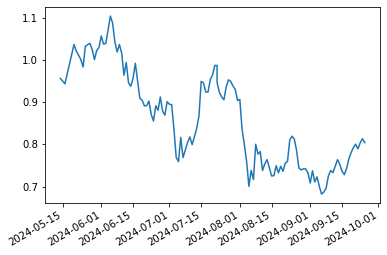

In [28]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [29]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [30]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [31]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [32]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9307
OMUSDT,0.0253
BNBUSDT,0.0213
TRXUSDT,0.0143
PEPEUSDT,0.0050
JASMYUSDT,0.0026
CKBUSDT,0.0008
BONKUSDT,0.0000
LDOUSDT,0.0000
RUNEUSDT,0.0000


In [34]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.445255
BTCUSDT,0.400000
BNBUSDT,0.084665
PEPEUSDT,0.055334
JASMYUSDT,0.014745


In [35]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [36]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.728583
OMUSDT,0.271417


## Real Portfolio vs Optimal

In [37]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,581.977157,0.285921,0.271417,0.014504
BTCUSDT,574.564050,0.282279,0.000000,0.000000
JASMYUSDT,295.004316,0.144933,0.000000,0.000000
SOLUSDT,278.270667,0.136712,0.000000,0.000000
ETHUSDT,182.821234,0.089819,0.000000,0.000000
TRXUSDT,74.312956,0.036509,0.728583,-0.692074
BBUSDT,47.484534,0.023329,0.000000,0.000000
BNBUSDT,1.014672,0.000499,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [38]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,581.977157,0.285921,0.445255,-0.159334
BTCUSDT,574.564050,0.282279,0.400000,-0.117721
JASMYUSDT,295.004316,0.144933,0.014745,0.130188
SOLUSDT,278.270667,0.136712,0.000000,0.000000
ETHUSDT,182.821234,0.089819,0.000000,0.000000
TRXUSDT,74.312956,0.036509,0.000000,0.000000
BBUSDT,47.484534,0.023329,0.000000,0.000000
BNBUSDT,1.014672,0.000499,0.084665,-0.084166
PEPEUSDT,0.000002,0.000000,0.055334,-0.055334


# Risk Reward Analysis

In [39]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [40]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

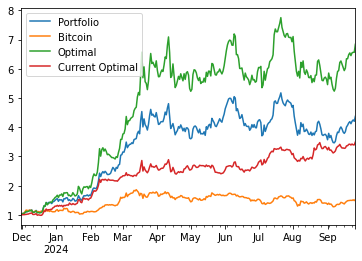

In [41]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [42]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

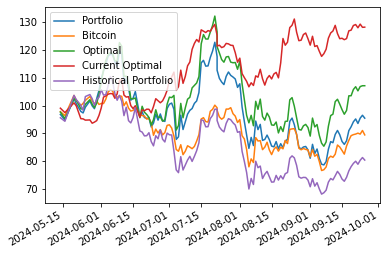

In [99]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [44]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-16,86.067575,82.583217,96.869468,123.579516,72.860240
2024-09-17,87.374404,85.509833,98.229240,123.978182,74.288060
2024-09-18,91.005355,87.535703,103.475453,126.756625,76.578064
2024-09-19,92.382042,89.203528,103.500487,126.996420,78.100735
2024-09-20,94.157051,89.561420,105.730517,128.661128,79.257782
2024-09-21,95.181993,89.770777,106.733378,129.004649,80.041385
2024-09-22,93.575055,90.095833,105.242973,127.848927,78.955810
2024-09-23,95.479507,89.756842,106.789520,129.157277,80.384976
2024-09-24,96.507412,91.054949,107.083081,128.010932,81.362290
2024-09-25,95.466217,89.467434,107.086467,128.072385,80.450751


## Volatilities

In [45]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.695677
dtype: float64

In [46]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.551614
dtype: float64

In [47]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.602484
Bitcoin            0.442644
Optimal            0.696803
Current Optimal    0.434419
dtype: float64

In [48]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2453361100199362

## Risk Contribution

In [49]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.107392,0.084665,0.018154,0.027369,0.003578,0.023790
BTCUSDT,0.212666,0.400000,0.057912,0.165110,0.064567,0.100543
JASMYUSDT,0.020791,0.014745,0.003359,0.008625,0.000529,0.008097
OMUSDT,9.108236,0.445255,0.903037,0.751310,0.649355,0.101955
PEPEUSDT,0.130211,0.055334,0.017539,0.047586,0.010471,0.037115


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.123586,0.271417,0.313171,0.519582,0.453745,0.065838
TRXUSDT,0.137715,0.728583,0.686829,0.480418,0.414580,0.065838


In [51]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.132048,0.29,0.384457,0.370872,0.204537,0.166335
BTCUSDT,-0.004164,0.28,0.251267,0.179720,0.044594,0.135127
JASMYUSDT,-0.003298,0.14,0.124526,0.198434,0.061764,0.136670
SOLUSDT,-0.009277,0.14,0.119080,0.140957,0.029280,0.111677
ETHUSDT,-0.015724,0.09,0.067661,0.070133,0.008043,0.062090
TRXUSDT,0.007561,0.04,0.043325,0.006311,0.000493,0.005818
BBUSDT,-0.009368,0.02,0.009685,0.033572,0.002698,0.030874


# Value At Risk

## Historical

In [52]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05839578676576957, -0.08161688882310224)

In [53]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05120353769042657, -0.07079577146269016)

In [54]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [55]:
var=historical_var.iloc[row]
var

OMUSDT      -0.007819
BTCUSDT     -0.015666
JASMYUSDT   -0.006737
SOLUSDT     -0.009521
ETHUSDT     -0.007823
TRXUSDT     -0.000926
BBUSDT      -0.002220
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050712
Name: 2024-08-27 00:00:00, dtype: float64

In [56]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.022710
BTCUSDT     -0.012905
JASMYUSDT   -0.013651
SOLUSDT     -0.010846
ETHUSDT     -0.005388
TRXUSDT     -0.000788
BBUSDT      -0.001997
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068285
dtype: float64

## Parametric

In [57]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07219997920156933, -0.09254041114773383)

In [58]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.0571560734267536, -0.07325828335400511)

## Multivariate

In [59]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06318022739091785, -0.08104340010908175)

In [60]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05497325453941826, -0.06980688886947584)

In [61]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.022232
BTCUSDT     -0.009548
JASMYUSDT   -0.009901
SOLUSDT     -0.007986
ETHUSDT     -0.003744
TRXUSDT     -0.000492
BBUSDT      -0.001687
Portfolio   -0.055591
dtype: float64

## Copulas

### Gaussian Copula

In [62]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0643947957143051, -0.08339352113855035)

In [63]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055449681784194724, -0.07005096181162127)

In [64]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.018857
BTCUSDT     -0.010822
JASMYUSDT   -0.011096
SOLUSDT     -0.008129
ETHUSDT     -0.004460
TRXUSDT     -0.000352
BBUSDT      -0.001793
Portfolio   -0.055508
dtype: float64

### Student Copula

In [65]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06339591626381959, -0.08210645278018601)

In [66]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05676380031558524, -0.07118703072191906)

In [67]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.020183
BTCUSDT     -0.010252
JASMYUSDT   -0.011678
SOLUSDT     -0.008022
ETHUSDT     -0.004108
TRXUSDT     -0.000309
BBUSDT      -0.002027
Portfolio   -0.056579
dtype: float64

### Gumbel Copula

In [68]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12237566065184576, -0.1763098554664744)

In [69]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07314218337757468, -0.09931804924634921)

In [70]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.046880
BTCUSDT     -0.007723
JASMYUSDT   -0.009303
SOLUSDT     -0.004941
ETHUSDT     -0.001550
TRXUSDT      0.000262
BBUSDT      -0.000145
Portfolio   -0.070280
dtype: float64

### Monte Carlo

In [71]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [72]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07328708334994877, -0.09194188513323541)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.057520582242680564, -0.07153859086370516)

In [74]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.022142
BTCUSDT     -0.010547
JASMYUSDT   -0.011410
SOLUSDT     -0.007751
ETHUSDT     -0.004079
TRXUSDT     -0.000352
BBUSDT      -0.001838
Portfolio   -0.058118
dtype: float64

## VaR Violation

In [75]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.057815,-0.102343,-0.087457,-0.023874
2024-01-15,-0.057815,-0.102345,-0.087383,0.018594
2024-01-16,-0.057815,-0.102825,-0.080553,0.056006
2024-01-17,-0.057815,-0.105127,-0.087536,-0.034145
2024-01-18,-0.057815,-0.107069,-0.091283,-0.032034
...,...,...,...,...
2024-09-22,-0.042984,-0.073059,-0.070206,-0.013964
2024-09-23,-0.042984,-0.073226,-0.071437,0.014695
2024-09-24,-0.042984,-0.071884,-0.068841,0.002749
2024-09-25,-0.042984,-0.069220,-0.065335,0.000032


In [76]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031579,-0.085068,-0.079065,-0.017493
2024-05-29,-0.028865,-0.082177,-0.074616,-0.010032
2024-05-30,-0.028865,-0.071155,-0.066318,0.036735
2024-05-31,-0.028865,-0.070295,-0.062002,0.027881
2024-06-01,-0.028865,-0.071646,-0.059943,0.041842
...,...,...,...,...
2024-09-22,-0.025421,-0.054830,-0.042876,-0.016883
2024-09-23,-0.025421,-0.055041,-0.043980,0.020352
2024-09-24,-0.025421,-0.047532,-0.038295,0.010766
2024-09-25,-0.025421,-0.046483,-0.040184,-0.010789


<AxesSubplot:>

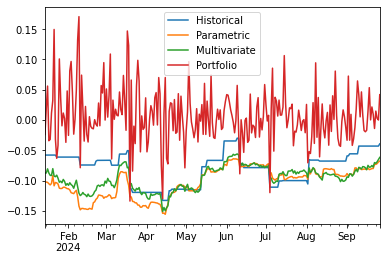

In [77]:
var_data.plot()

<AxesSubplot:>

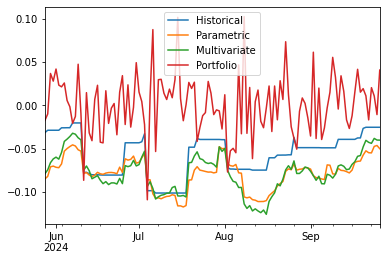

In [78]:
current_var_data.plot()

In [79]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.019455,0.011673,0.011673
Kupiec Stat,6.510675,11.363761,11.363761
P-value,0.010723,0.000749,0.000749


In [80]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057377,0.02459,0.02459
Kupiec Stat,0.133706,2.024128,2.024128
P-value,0.71462,0.154818,0.154818


## Principal Component Analysis

### Historical PCA

In [81]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78935522, 0.06523334, 0.05386689, 0.04707383, 0.04447073])

In [82]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014142
ADAUSDT     0.014406
ALGOUSDT    0.015927
APTUSDT     0.015288
ARBUSDT     0.015606
              ...   
WBTCUSDT    0.010043
WLDUSDT     0.021496
XLMUSDT     0.009585
XRPUSDT     0.009186
XTZUSDT     0.014487
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

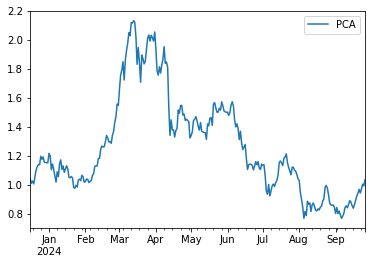

In [83]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

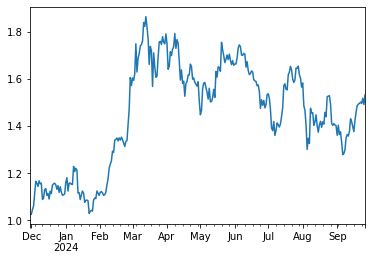

In [84]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [85]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
XTZUSDT      0.337759
ADAUSDT      0.341383
ALGOUSDT     0.347698
WBETHUSDT    0.350872
               ...   
PEPEUSDT     0.994852
FLOKIUSDT    1.007539
WLDUSDT      1.045254
CKBUSDT      1.149381
OMUSDT       1.312958
Length: 65, dtype: float64

<AxesSubplot:>

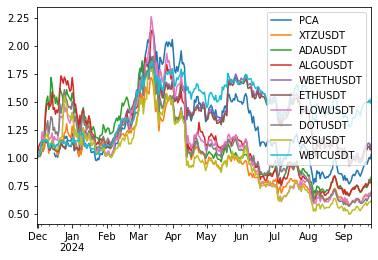

In [86]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

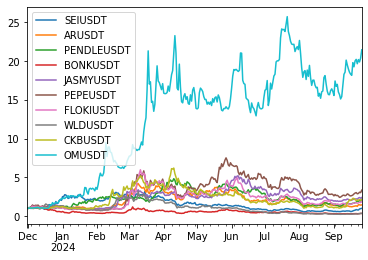

In [87]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [88]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67080386, 0.13876034, 0.08728363, 0.07119511, 0.03195705])

In [89]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.100333
BTCUSDT      0.063959
JASMYUSDT    0.153917
SOLUSDT      0.104003
ETHUSDT      0.086346
TRXUSDT      0.015142
BBUSDT       0.245524
BNBUSDT      0.067959
PEPEUSDT     0.162817
Name: PC1, dtype: float64

<AxesSubplot:>

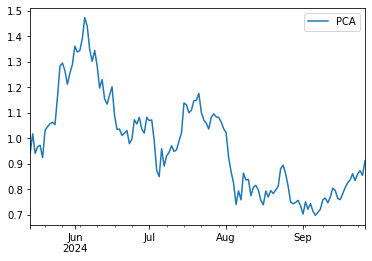

In [90]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

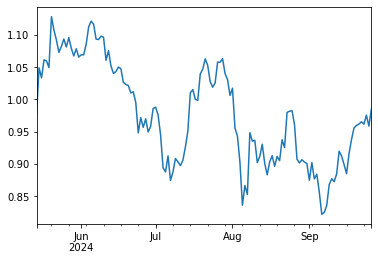

In [91]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [92]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.332042
SOLUSDT      0.343893
BTCUSDT      0.366024
BNBUSDT      0.366252
JASMYUSDT    0.425548
PEPEUSDT     0.457993
OMUSDT       0.537022
TRXUSDT      0.542803
BBUSDT       0.621403
dtype: float64

<AxesSubplot:>

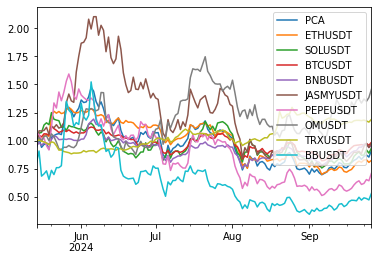

In [93]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [94]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.939768
BBUSDT       1.682806
JASMYUSDT    1.282218
SOLUSDT      1.167019
BTCUSDT      1.000000
OMUSDT       0.987708
ETHUSDT      0.954966
BNBUSDT      0.671517
TRXUSDT      0.280267
Name: BTCUSDT, dtype: float64

In [95]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.711543
BBUSDT       1.687735
JASMYUSDT    1.327275
SOLUSDT      1.054083
BTCUSDT      1.000000
ETHUSDT      0.877879
BNBUSDT      0.729431
OMUSDT       0.313272
TRXUSDT      0.019289
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [96]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.622138,0.000000,0.0,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.150844,0.000000,0.0,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.0,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.000000,0.111977,0.0,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.0,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.0,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.0,0.000000,0.712514,0.000000,0.000000


In [97]:
(rolling_optimization>0.25).sum()

OMUSDT       3
BTCUSDT      1
JASMYUSDT    2
SOLUSDT      0
ETHUSDT      0
TRXUSDT      5
BBUSDT       1
BNBUSDT      0
PEPEUSDT     1
dtype: int64

In [98]:
pd.read_excel('PnL Binance.xlsx')

,Date,Daily PnL,Cumulative Pnl,%
0,2024-09-25,-19.25,-321.89,-0.1367
1,2024-09-24,20.90,-302.65,-0.1285
2,2024-09-23,31.10,-323.55,-0.1374
3,2024-09-22,-23.78,-354.64,-0.1506
4,2024-09-21,17.09,-330.86,-0.1405
...,...,...,...,...
137,2024-05-11,2.89,0.82,0.0023
138,2024-05-10,-3.56,-2.07,-0.0059
139,2024-05-09,2.43,1.49,0.0107
140,2024-05-08,-1.62,-0.94,-0.0134
